# LFW

In [ ]:
#| default_exp lfw

In [ ]:
#| export
from abc import ABC, abstractmethod

import torchvision
from fastai.vision.all import *
from sklearn.model_selection import KFold

import fast_datasets.patches
from fast_datasets.utils import return_list

In [ ]:
#| export
class LFW(ABC):
    TEST_ITEMS_FILE_NAME: str

    def __init__(self, root=Path.home()/'.fastai'):
        torchvision.datasets.LFWPeople(root, split='10fold', image_set='original', download=True)
        torchvision.datasets.LFWPeople(root, split='train', image_set='original', download=True)
        torchvision.datasets.LFWPeople(root, split='test', image_set='original', download=True)
        self.root = root/'lfw-py'

    def test(self):
        items = self._parse_pairs(self.root / self.TEST_ITEMS_FILE_NAME)
        splits = KFold(n_splits=10, shuffle=False).split(range_of(items))
        return [self._load(items=items, splits=s) for s in splits]

    @abstractmethod
    def _parse_pairs(self, pairs_txt_path):
        pass

    @abstractmethod
    def _load(self, **kwargs):
        pass

    def _get_path(self, name, num) -> Path:
        return self.root / 'lfw' / name / f'{name}_{num:04d}.jpg'


class LFWDevMixin(LFW):
    DEV_TRAIN_ITEMS_FILE_NAME: str
    DEV_TEST_ITEMS_FILE_NAME: str

    def dev(self):
        train_pairs = self._parse_pairs(self.root / self.DEV_TRAIN_ITEMS_FILE_NAME)
        valid_pairs = self._parse_pairs(self.root / self.DEV_TEST_ITEMS_FILE_NAME)
        items = valid_pairs+train_pairs

        return self._load(
            items=items,
            splits=IndexSplitter(range_of(valid_pairs))(items)
        )


class LFWPeople(LFWDevMixin, LFW):
    TEST_ITEMS_FILE_NAME = 'people.txt'
    DEV_TRAIN_ITEMS_FILE_NAME = 'peopleDevTrain.txt'
    DEV_TEST_ITEMS_FILE_NAME = 'peopleDevTest.txt'
    
    @return_list
    def _parse_pairs(self, pairs_txt_path):
        lines = [l.split() for l in pairs_txt_path.readlines()]
        for l in lines[1:]:
            if len(l) == 1:
                continue
            name, num_images = l
            for i in range(1, int(num_images)+1):
                yield self._get_path(name, i)

    def _load(self, **kwargs):
        return Datasets(
            tfms=[
                PILImage.create,
                [parent_label, lambda s: s.replace('_', ' '), Categorize()]
            ],
            train_setup=False,
            **kwargs
        )


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


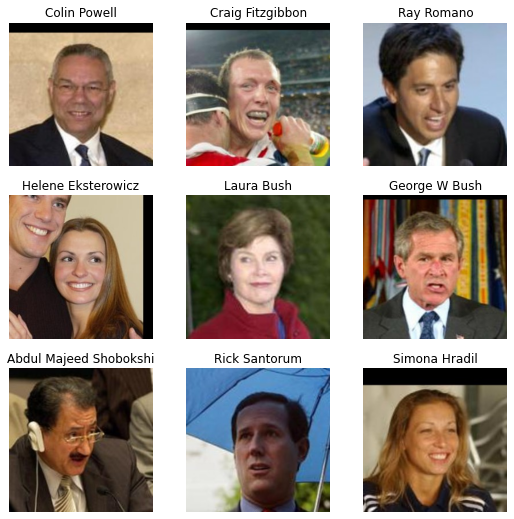

In [ ]:
LFWPeople().dev().dls().show_batch()

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()